In [2]:
from augur.utils import json_to_tree
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from Bio import SeqIO
from scipy import stats
import matplotlib.gridspec as gridspec
from collections import Counter
import requests

Find whether there is a correlation between nsp6 deletion (3675-3677) and a higher number of S1 mutations

In [17]:
tree_url = 'https://nextstrain-blab.s3.amazonaws.com/ncov_adaptive-evolution_2021-05-15.json'

tree_json = requests.get(tree_url).json()

#Put tree in Bio.Phylo format
tree = json_to_tree(tree_json)

In [4]:
def get_parent(tree, child_clade):
    node_path = tree.get_path(child_clade)
    return node_path

In [18]:
#Find the path from root to internal node and accumulate all mutations that have occurred along this path
#Keep track of these for RdRp and store it as a node attribute

def consolidate_deletions(mutation_list):
    """
    For deletion mutations, consider adjacent sites as part of the same deletion
    """
    mutation_count = len([x for x in mutation_list if x[-1]!='-'])
    deletions_only = sorted([int(x[1:-1]) for x in mutation_list if x[-1]=='-'])

    # if there are deletions, count a run of consecutive sites as a single deletion/mutation
    if len(deletions_only) != 0:
        mutation_count+=1

        deletion_tracker = deletions_only[0]
        for deleted_pos in deletions_only[1:]:
            if deleted_pos == deletion_tracker+1:
                pass
            else:
                mutation_count+=1
            deletion_tracker = deleted_pos
    return mutation_count

def remove_reversions(mutation_list):
    """
    If site mutates and then reverts, do not count this in the mutation tally.
    If site mutates and then mutates again (but not a reversion), count only the second mutation
    """
    mutation_list_pos = [int(x[1:-1]) for x in mutation_list]
    sites_mutated_twice = set([x for x in mutation_list_pos if mutation_list_pos.count(x) > 1])
    # find if twice-mutated site was a reversion
    for site in sites_mutated_twice:
        muts_at_site = [mut for mut in mutation_list if int(mut[1:-1])==site]

        # if site reverts, remove all mutations at this site
        if muts_at_site[0][0] == muts_at_site[-1][-1]:
            for mut in range(len(muts_at_site)):
                mutation_list.remove(muts_at_site[mut])
        # if the site mutates multiple times, but doesn't revert, keep last mutation
        else:
            for mut in range(len(muts_at_site)-1):
                mutation_list.remove(muts_at_site[mut])
    return mutation_list
    
    


for node in tree.find_clades():

    
    #Find all parents of the node
    parents = get_parent(tree, node)

    #Find rdrp mutations that occur in the parents
    parents_rdrp_muts = []

    for parent in parents:
        if hasattr(parent, "branch_attrs") and "mutations" in parent.branch_attrs:
            #find RdRp muts
            if "ORF1a" in parent.branch_attrs["mutations"]:
                for mut in parent.branch_attrs["mutations"]["ORF1a"]:
                    if int(mut[1:-1]) in range(4492,4401):
                        #renumber mut according to rdrp protein
                        rdrp_mut = f'{mut[0]}{int(mut[1:-1])-4492}{mut[-1]}'
                        parents_rdrp_muts+=[rdrp_mut]
            if "ORF1b" in parent.branch_attrs["mutations"]:
                for mut in parent.branch_attrs["mutations"]["ORF1b"]:
                    if int(mut[1:-1]) in range(1,923):
                        #renumber mut according to rdrp protein
                        rdrp_mut = f'{mut[0]}{int(mut[1:-1])+9}{mut[-1]}'
                        parents_rdrp_muts+=[rdrp_mut]

    # remove reversion mutations from each list
    parents_rdrp_muts = remove_reversions(parents_rdrp_muts)



    # count deletion of adjacent nucleotides as one mutation event
    rdrp_mutation_count = consolidate_deletions(parents_rdrp_muts)


    node.node_attrs["rdrp_muts"] = rdrp_mutation_count

In [6]:
def final_pos_genotype(mutation_list, mutation):
    """
    Given a list of mutations that occurred at certain position, 
    find the whether the final genotype at this position is the specified mutation or not (return True or False)
    """

    
    if len(mutation_list) == 0:
        mutation_at_pos = False 
        
    elif len(mutation_list) == 1:
        if mutation_list[0][-1] == mutation:
            mutation_at_pos = True
        else:
            mutation_at_pos = False 
        
    
    elif len(mutation_list) > 1:
        if mutation_list[-1][-1] == mutation:
            mutation_at_pos = True
        else:
            mutation_at_pos = False 


    return mutation_at_pos

In [19]:
to_plot = []

for node in tree.find_clades(terminal=False):
    
    if len(node.get_terminals()) >=10:

        if "S1_mutations" in node.node_attrs:
            s1_mutations = node.node_attrs["S1_mutations"]["value"]
            rdrp_mutations =  node.node_attrs["rdrp_muts"]
            date = node.node_attrs["num_date"]["value"]

            #Find all parents of the node
            parents = get_parent(tree, node)

            #Find mutations that occur in the parents
            parents_3676_muts = []
            parents_3255_muts = []
            parents_3606_muts = []
            parents_N205_muts = []
            parents_N234_muts = []
            parents_S501_muts = []
            parents_S452_muts = []
            parents_M82_muts = []
            parents_N194_muts = []


            for parent in parents:
                if hasattr(parent, "branch_attrs") and "mutations" in parent.branch_attrs:
                    #find specific mutations of interest
                    if "ORF1a" in parent.branch_attrs["mutations"]:
                        for mut in parent.branch_attrs["mutations"]["ORF1a"]:
                            if int(mut[1:-1])==3676:
                                parents_3676_muts+=[mut]
                            elif int(mut[1:-1]) == 3255:
                                parents_3255_muts+=[mut]
                            elif int(mut[1:-1]) == 3606:
                                parents_3606_muts+=[mut]

                    if "N" in parent.branch_attrs["mutations"]:
                        for mut in parent.branch_attrs["mutations"]["N"]:
                            if int(mut[1:-1])==205:
                                parents_N205_muts+=[mut]
                            elif int(mut[1:-1])==234:
                                parents_N234_muts+=[mut]
                            elif int(mut[1:-1])==194:
                                parents_N194_muts+=[mut]

                    if "M" in parent.branch_attrs["mutations"]:
                        for mut in parent.branch_attrs["mutations"]["M"]:
                            if int(mut[1:-1])==82:
                                parents_M82_muts+=[mut]

                    if "S" in parent.branch_attrs["mutations"]:
                        for mut in parent.branch_attrs["mutations"]["S"]:
                            if int(mut[1:-1])==501:
                                parents_S501_muts+=[mut]
                            elif int(mut[1:-1])==452:
                                parents_S452_muts+=[mut]


            # remove reversion mutations from each list and get final genotype at 3676
            deletion_at_3676 = final_pos_genotype(parents_3676_muts, '-')

            mutation_at_3255 = final_pos_genotype(parents_3255_muts, 'I')

            mutation_at_3606 = final_pos_genotype(parents_3606_muts, 'F')

            mutation_at_N205 = final_pos_genotype(parents_N205_muts, 'I')

            mutation_at_N234 = final_pos_genotype(parents_N234_muts, 'I')

            mutation_at_S501 = final_pos_genotype(parents_S501_muts, 'Y')

            mutation_at_S452 = final_pos_genotype(parents_S452_muts, 'R')

            mutation_at_M82 = final_pos_genotype(parents_M82_muts, 'T')

            mutation_at_N194 = final_pos_genotype(parents_N194_muts, 'L')

            if 'emerging_lineage' in node.node_attrs:
                emerging_lineage = node.node_attrs['emerging_lineage']['value']


            to_plot.append({'clade': node.name, 
                            'ORF1a_3676-': deletion_at_3676, 
                            'ORF1a_3255I': mutation_at_3255,
                            'ORF1a_3606F': mutation_at_3606,
                            'N_205I': mutation_at_N205,
                            'N_234I': mutation_at_N234,
                            'M_82T': mutation_at_M82, 
                            'N_194L': mutation_at_N194, 
                            'S_501Y': mutation_at_S501,
                            'S_452R': mutation_at_S452,
                            's1_mutations': s1_mutations, 
                            'rdrp_mutations':rdrp_mutations,
                            'emerging_lineage': emerging_lineage, 
                            'date': date})

to_plot_df = pd.DataFrame(to_plot)

In [20]:
#find earliest occurrence of each mutation and limit dataset to that
earliest_muts = {('ORF1a','G3676-'): 2022, ('ORF1a','T3255I'): 2022, 
                 ('ORF1a','L3606F'): 2022, ('N', 'T205I'): 2022, 
                 ('N', 'S194L'):2022, ('N', 'M234I'):2022, ('M', 'I82T'):2022, 
                 ('S', 'N501Y'):2022, ('S', 'L452R'):2022}


for gene, mut in earliest_muts.keys():
    
    for node in tree.find_clades(terminal=False):
        if hasattr(node, "branch_attrs") and "mutations" in parent.branch_attrs:
            if gene in node.branch_attrs["mutations"]:
                if mut in node.branch_attrs["mutations"][gene]:
                    date = node.node_attrs["num_date"]["value"]
                    if date < earliest_muts[(gene, mut)]:
                        earliest_muts[(gene, mut)] = date


In [21]:
# restructure datafame to have a column for s1 and rdrp mutation mean 
# with and without each substitution 
# with data limited to after the first occurrence of this substitution

with_and_without_muts = []

for gene, mut in earliest_muts.keys():
    earliest_date = earliest_muts[(gene, mut)]
    date_subset_df = to_plot_df[to_plot_df['date']>=earliest_date]
    
    to_plot_column = f'{gene}_{mut[1:-1]}{mut[-1]}'
    
    mut_s1 = list(date_subset_df[date_subset_df[to_plot_column]==True]['s1_mutations'])
    nomut_s1 = list(date_subset_df[date_subset_df[to_plot_column]==False]['s1_mutations'])
    
    mut_rdrp = list(date_subset_df[date_subset_df[to_plot_column]==True]['rdrp_mutations'])
    nomut_rdrp = list(date_subset_df[date_subset_df[to_plot_column]==False]['rdrp_mutations'])


    
    for d1 in mut_s1:
        with_and_without_muts.append({'mutation': to_plot_column, 'has_mutation': True, 's1_muts': d1})
    for d2 in nomut_s1:
        with_and_without_muts.append({'mutation': to_plot_column, 'has_mutation': False, 's1_muts': d2})
    for d3 in mut_rdrp:
        with_and_without_muts.append({'mutation': to_plot_column, 'has_mutation': True, 'rdrp_muts': d3})
    for d4 in nomut_rdrp:
        with_and_without_muts.append({'mutation': to_plot_column, 'has_mutation': False, 'rdrp_muts': d4})
    
with_and_without_muts_df = pd.DataFrame(with_and_without_muts)

In [22]:
all_muts = list(with_and_without_muts_df['mutation'].unique())

ttest_stats_s1 = {}
ttest_stats_rdrp = {}

for mut in all_muts:

    s1_mut = list(with_and_without_muts_df[(with_and_without_muts_df['mutation']==mut) & 
                                    (with_and_without_muts_df['has_mutation']==True)]['s1_muts'].dropna())
    s1_nomut = list(with_and_without_muts_df[(with_and_without_muts_df['mutation']==mut) & 
                                    (with_and_without_muts_df['has_mutation']==False)]['s1_muts'].dropna())
    
    rdrp_mut = list(with_and_without_muts_df[(with_and_without_muts_df['mutation']==mut) & 
                                    (with_and_without_muts_df['has_mutation']==True)]['rdrp_muts'].dropna())
    rdrp_nomut = list(with_and_without_muts_df[(with_and_without_muts_df['mutation']==mut) & 
                                    (with_and_without_muts_df['has_mutation']==False)]['rdrp_muts'].dropna())

    pvalue_s1 = stats.ttest_ind(s1_mut, s1_nomut).pvalue
    
    pvalue_rdrp = stats.ttest_ind(rdrp_mut, rdrp_nomut).pvalue
    
    ttest_stats_s1[mut] = pvalue_s1
    ttest_stats_rdrp[mut] = pvalue_rdrp
    

In [18]:
ttest_stats_s1

{'ORF1a_3676-': 1.153333299137412e-66,
 'ORF1a_3255I': 0.016616664575021582,
 'ORF1a_3606F': 8.449567256593543e-08,
 'N_205I': 0.05924304475554794,
 'N_194L': 2.7884559988098786e-06,
 'N_234I': 0.000698395784646072,
 'M_82T': 1.4521231389617433e-08}

In [58]:
ttest_stats_rdrp

{'ORF1a_3676-': 0.38800499772341634,
 'ORF1a_3255I': 1.70792894315281e-08,
 'ORF1a_3606F': 1.612348648405445e-07,
 'N_205I': 0.017542578454459078,
 'N_194L': 0.4669241548377664,
 'N_234I': 0.0006034654398700368,
 'M_82T': 4.338544065319938e-24}

In [23]:
def fig4_supp(filename=None):
    cmap1 = {False:"#ABABAB",True:"#4770eb"}
    cmap2 = {False:"#ABABAB",True:"#ff8c3a"}

    f = plt.figure(figsize=(10,10))

    gs = gridspec.GridSpec(2, 1,height_ratios=[2,1])

    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])


    ax1 = sns.pointplot(x='mutation', y='s1_muts', 
                      hue = 'has_mutation', palette=cmap1,
                      dodge = 0.25, join=False, ci='sd', scale=2.0,errwidth=1.5, capsize=0.05,
                      data=with_and_without_muts_df, ax=ax1)

    ax2 = sns.pointplot(x='mutation', y='rdrp_muts', 
                      hue = 'has_mutation', palette=cmap2,
                      dodge = 0.25, join=False, ci='sd', scale=2.0, errwidth=1.5, capsize=0.05,
                      data=with_and_without_muts_df, ax=ax2)


    ax1.set_xlabel('', fontsize = 14)
    ax1.set_ylabel('Number of S1 mutations', fontsize = 14)
    ax2.set_xlabel('', fontsize = 14)
    ax2.set_ylabel('Number of RdRp mutations', fontsize = 14)
    ax2.set_ylim(0,4)
    ax2.set_yticks([0,2,4])
    sns.despine(left=False, bottom=False)

    handles1, labels1 = ax1.get_legend_handles_labels()
    lgd = ax1.legend(handles1, labels1, title='Has Mutation')

    handles2, labels2 = ax2.get_legend_handles_labels()
    lgd = ax2.legend(handles2, labels2, title='Has Mutation')

    _, xlabels = plt.xticks()
    xlabels[0] = 'ORFa1_3675-3677del'
    ax1.set_xticklabels('', size = 8, rotation=20)
    ax2.set_xticklabels(xlabels, size = 12, rotation=30)
    
    if filename:
        fig.savefig(filename, dpi=300, bbox_inches='tight')


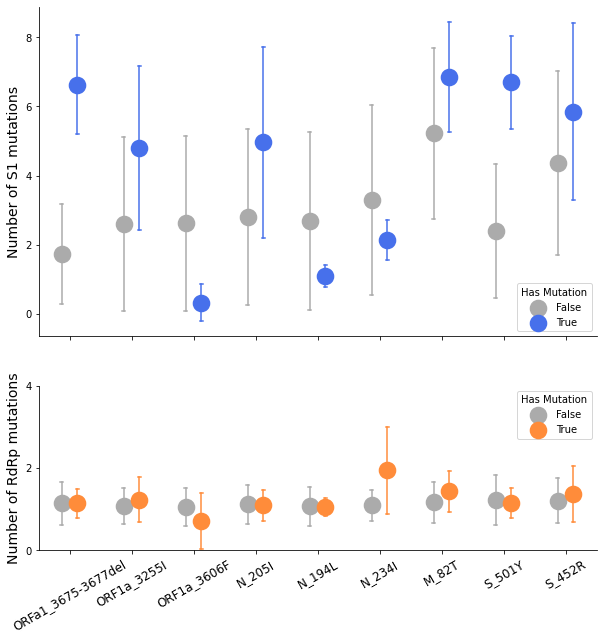

In [24]:
fig4_supp()

Test expectation by randomly throwing the 3675-3677 deletions on branches of the tree and computing average number of S1 mutations after. Make sure the randomization makes phylogenetic-sense: 3675-3677 deletions occur in independent lineages, not in parents/children

In [10]:
# make dictionary with gene name as key and reference sequence of that gene as value

reference_sequence = {}

for record in SeqIO.parse(open("reference_seq_edited.gb","r"), "genbank"):
    for feature in record.features:
        if feature.type == 'CDS':
            gene_seq = feature.location.extract(record.seq).translate()
            reference_sequence[feature.qualifiers['gene'][0]] = gene_seq


/Users/katekistler/anaconda3/envs/ncov/lib/python3.6/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


In [11]:
def count_independent_occurrences(mutation_type='aa'):
    
    """
    Function to determine all mutations that occur on internal branches of the phylogeny. 
    Only branches with at least 10 descendents are used in order to reduce the impact of 
    sequencing error and phylogenetic reconstruction (seen mostly at tips) on this analysis
    
    `mutation_type` can be set to 'aa' (to look at specific amino acid substitution) 
    or 'site' (to look at any nonsynonymous substitution that happens at a specific residue)
    
    returns `all_mutations_unique`: a list of all mutations seen on internal branches and
    `independent_occurrences_all_mutations`: a dictionary with each observed mutation as a key, 
    and the number of times that mutation occurs on internal branches as the value of that key.
    """
    
    all_mutations = []


    #only look at mutations on internal branches
    for node in tree.find_clades(terminal=False):
        
        # only consider mutations on branches that give rise to a clade of at least 10 tips
        if len(node.get_terminals()) >=10:

            if hasattr(node, 'branch_attrs'):
                for gene, mut_list in node.branch_attrs["mutations"].items():
                    # not considering synonymous mutations for now
                    if gene!= 'nuc':
                        for mut in mut_list:
                            
                            if mutation_type == 'aa':
                                # look at specific nonsyn muts
                                gene_mutation = f'{gene}_{mut}'

                                
                            elif mutation_type == 'site':
                                # look at mutation to a codon (without regard to identity of mutation)
                                gene_mutation = f'{gene}_{mut[1:-1]}'
                                
                            
                            # append mutation to a list of all observed mutations
                            # exclude if mutation is in stop codon position of gene
                            if int(mut[1:-1])!=len(reference_sequence[gene]):
                                all_mutations.append(gene_mutation)
                


    all_mutations_unique = list(set(all_mutations))    

    independent_occurrences_all_mutations = Counter(all_mutations)
    

    return all_mutations_unique, independent_occurrences_all_mutations


In [12]:
all_mutations_unique, independent_occurrences_all_mutations = count_independent_occurrences()
nsp6_del_occurrences = independent_occurrences_all_mutations['ORF1a_S3675-']

In [13]:
total_branchs = 0
for node in tree.find_clades(terminal=False):
    total_branchs+=1

In [14]:
# find all branch lengths
root_date = tree.root.node_attrs['num_date']['value']

# keep track of parts of paths that have already been considered
paths_segments_already_used_all = []

# store all wait times between branchs
branch_lengths_all = []
branch_names_all = []

for node in tree.find_clades(terminal=False):


    node_path = get_parent(tree, node)

    # find the branch length (in decimal years) between node and previous node
    path_dates = [n.node_attrs['num_date']['value'] for n in node_path]

    if len(path_dates) > 1:
        path_dates_with_root = [root_date] + path_dates
        branch_lengths = [j-i for i, j in zip(path_dates_with_root[:-1], path_dates_with_root[1:])]

#         branch_lengths = [j-i for i, j in zip(path_dates[:-1], path_dates[1:])]


        for n_index in range(len(node_path)):
            
            # name of the node at the end of the branch
            # branch length will be assigned to this node because 
            # it is the length of the branch leading to this node
            branch_name = node_path[n_index].name
            if n_index==0:
                preceding_node_name = tree.root.name
            else:
                preceding_node_name = node_path[n_index-1].name


            if [preceding_node_name, branch_name] not in paths_segments_already_used_all:

                branch_length = branch_lengths[n_index]

                if branch_length<0:
                    branch_length = 0.0

                branch_lengths_all.append(branch_length)
                branch_names_all.append(branch_name)
#                 branch_names_all.append([root_name, branch_name])
                paths_segments_already_used_all.append([preceding_node_name, branch_name])

            


In [15]:
def randomize_mutations_on_tree_mulinomial(num_occurrences, branch_lengths, branch_names):
    
    # multinomial draw to randomize mutations on tree
    branch_lengths_normalized = [x/sum(branch_lengths) for x in branch_lengths]

    hits = list(np.random.multinomial(num_occurrences, branch_lengths_normalized, size=1))[0]
    
    branchs_with_mut = dict(zip(branch_names, hits))
    branchs_with_mut_list = [k for k,v in branchs_with_mut.items() if v!=0]
    
    parents_of_all_hits = []

    for node in tree.find_clades():
        if node.name in branchs_with_mut_list:
            parents = get_parent(tree, node)[:-1]
            parent_names= [p.name for p in parents]
            parents_of_all_hits+=parent_names
            
    for node in tree.find_clades():
        if node.name in branchs_with_mut_list:
            if node.name in parents_of_all_hits:
                branchs_with_mut_list = 'bad_randomization'

    return branchs_with_mut_list
            

In [21]:
random_df = pd.DataFrame()

x=0
while x<100:
    branchs_with_mut_list = randomize_mutations_on_tree_mulinomial(nsp6_del_occurrences, branch_lengths_all, branch_names_all)
    
    if branchs_with_mut_list=='bad_randomization':
        pass
        
    else:
        x+=1
        random_to_plot_df = s1_muts_after_random(branchs_with_mut_list)
        random_df = pd.concat([random_df, random_to_plot_df], ignore_index=True)
    

In [22]:
empirical_nsp6_df = with_and_without_muts_df[with_and_without_muts_df['mutation']=='ORF1a_3676-'].rename(columns={"s1_muts": "s1_mutations",
                                                                                                                  "rdrp_muts": "rdrp_mutations"})
 

random_df = random_df.drop(columns=['clade', 'date'])

compare_to_random_df = pd.concat([random_df, empirical_nsp6_df], ignore_index=True)

print(compare_to_random_df)
                                                                                                                  

                      mutation  has_mutation  s1_mutations  rdrp_mutations
0       ORF1a_3675del_expected         False           0.0             0.0
1       ORF1a_3675del_expected         False           0.0             0.0
2       ORF1a_3675del_expected         False           0.0             0.0
3       ORF1a_3675del_expected         False           0.0             0.0
4       ORF1a_3675del_expected         False           0.0             0.0
...                        ...           ...           ...             ...
233021             ORF1a_3676-         False           NaN             1.0
233022             ORF1a_3676-         False           NaN             1.0
233023             ORF1a_3676-         False           NaN             1.0
233024             ORF1a_3676-         False           NaN             1.0
233025             ORF1a_3676-         False           NaN             1.0

[233026 rows x 4 columns]


In [21]:
expected_3675_s1_mutations = list(compare_to_random_df[(compare_to_random_df['mutation']=='ORF1a_3675del_expected') 
                                                       & (compare_to_random_df['has_mutation']==True)]['s1_mutations'].dropna())

expected_no_3675_s1_mutations = list(compare_to_random_df[(compare_to_random_df['mutation']=='ORF1a_3675del_expected') 
                                                       & (compare_to_random_df['has_mutation']==False)]['s1_mutations'].dropna())

expected_p_value_s1 =stats.ttest_ind(expected_3675_s1_mutations, expected_no_3675_s1_mutations).pvalue

observed_3675_s1_mutations = list(compare_to_random_df[(compare_to_random_df['mutation']=='ORF1a_3676-') 
                                                       & (compare_to_random_df['has_mutation']==True)]['s1_mutations'].dropna())

observed_no_3675_s1_mutations = list(compare_to_random_df[(compare_to_random_df['mutation']=='ORF1a_3676-') 
                                                       & (compare_to_random_df['has_mutation']==False)]['s1_mutations'].dropna())


observed_p_value_rdrp =stats.ttest_ind(observed_3675_s1_mutations, observed_no_3675_s1_mutations).pvalue


expected_3675_rdrp_mutations = list(compare_to_random_df[(compare_to_random_df['mutation']=='ORF1a_3675del_expected') 
                                                       & (compare_to_random_df['has_mutation']==True)]['rdrp_mutations'].dropna())

expected_no_3675_rdrp_mutations = list(compare_to_random_df[(compare_to_random_df['mutation']=='ORF1a_3675del_expected') 
                                                       & (compare_to_random_df['has_mutation']==False)]['rdrp_mutations'].dropna())

expected_p_value_rdrp =stats.ttest_ind(expected_3675_rdrp_mutations, expected_no_3675_rdrp_mutations).pvalue

observed_3675_rdrp_mutations = list(compare_to_random_df[(compare_to_random_df['mutation']=='ORF1a_3676-') 
                                                       & (compare_to_random_df['has_mutation']==True)]['rdrp_mutations'].dropna())

observed_no_3675_rdrp_mutations = list(compare_to_random_df[(compare_to_random_df['mutation']=='ORF1a_3676-') 
                                                       & (compare_to_random_df['has_mutation']==False)]['rdrp_mutations'].dropna())


observed_p_value_rdrp =stats.ttest_ind(observed_3675_rdrp_mutations, observed_no_3675_rdrp_mutations).pvalue


print(expected_p_value_s1, observed_p_value_s1, expected_p_value_rdrp, observed_p_value_rdrp)

NameError: name 'observed_p_value_s1' is not defined

In [26]:
def fig4a(filename=None):
    cmap1 = {False:"#ABABAB",True:"#4770eb"}
    cmap2 = {False:"#ABABAB",True:"#ff8c3a"}

    f = plt.figure(figsize=(6,8))

    gs = gridspec.GridSpec(2, 1,height_ratios=[2,1])

    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])


    ax1 = sns.pointplot(x='mutation', y='s1_mutations', 
                      hue = 'has_mutation', palette=cmap1,
                      dodge = 0.25, join=False, ci='sd', scale=1.5,errwidth=1.5, 
                        capsize=0,
                      data=compare_to_random_df, ax=ax1)

    ax2 = sns.pointplot(x='mutation', y='rdrp_mutations', 
                        hue = 'has_mutation', palette=cmap2,
                        dodge = 0.25, join=False, ci='sd', scale=1.5, errwidth=1.5, 
                        capsize=0,
                      data=compare_to_random_df, ax=ax2)


    ax1.set_xlabel('', fontsize = 14)
    ax1.set_ylabel('Number of S1 mutations', fontsize = 12)
    ax2.set_xlabel('', fontsize = 14)
    ax2.set_ylabel('Number of RdRp mutations', fontsize = 12)
    ax2.set_ylim(0,4)
    ax2.set_yticks([0,2,4])
    sns.despine(left=False, bottom=False)

    handles1, labels1 = ax1.get_legend_handles_labels()
    lgd = ax1.legend(handles1, labels1, loc='lower right', title='ORF1a:3675-3677del', bbox_to_anchor=(1.1,0))

    handles2, labels2 = ax2.get_legend_handles_labels()
    lgd = ax2.legend(handles2, labels2, title='ORF1a:3675-3677del', bbox_to_anchor=(1.1,1.0))

    _, xlabels = plt.xticks()
    xlabels[0] = 'expected'
    xlabels[1] = 'observed'
    ax1.set_xticklabels('', size = 8, rotation=20)
    ax2.set_xticklabels(xlabels, size = 12, rotation=30)
    
#     ax1.set_title('Clades with ORF1a:3675-3677 deletion', size=14)

    plt.figtext(0.04, 0.88, 'B', fontsize=24, fontweight='bold')

    if filename:
        f.savefig(filename, dpi=300, bbox_inches='tight')


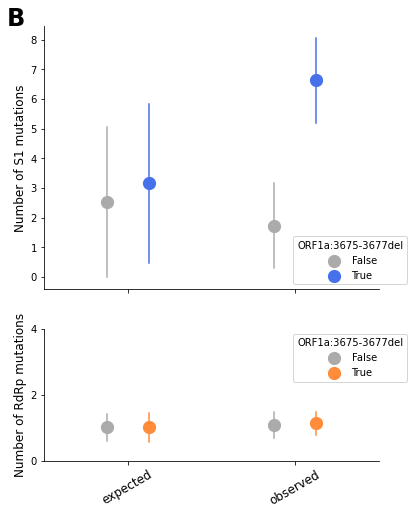

In [27]:
fig4b(filename='plots/fig4b_20210515.png')

In [15]:
def s1_muts_after_random(random_branch_list):
    
    random_to_plot = []
    
    for node in tree.find_clades(terminal=False):

        if len(node.get_terminals()) >=10:

            if "S1_mutations" in node.node_attrs:
                s1_mutations = node.node_attrs["S1_mutations"]["value"]
                rdrp_mutations =  node.node_attrs["rdrp_muts"]
                date = node.node_attrs["num_date"]["value"]

                #Find all parents of the node
                parents = get_parent(tree, node)

                # if parent is one of the randomly chosen branches that has a mutation
                if len(parents)>0:
                    for parent in parents:
                        if parent.name in random_branch_list:
                            ORF1a_3675del_random = True
                        else:
                            ORF1a_3675del_random = False


                    random_to_plot.append({'clade': node.name,
                                           'mutation': 'ORF1a_3675del_expected',
                                           'has_mutation': ORF1a_3675del_random,
                                           's1_mutations': s1_mutations, 
                                           'rdrp_mutations':rdrp_mutations, 
                                           'date': date})

    random_to_plot_df = pd.DataFrame(random_to_plot)
    
    return random_to_plot_df